In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Load dataset
df = pd.read_csv("Dataset_Uber Traffic.csv")

In [31]:
# Preprocess dataset
# Handling different date formats
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True, errors='coerce')  # Convert to datetime
df = df.dropna(subset=['DateTime'])  # Drop rows where datetime conversion failed
df.sort_values(by='DateTime', inplace=True)  # Sort by date
df.set_index('DateTime', inplace=True)

In [32]:
# Feature Engineering
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [33]:
# Define target variable (number of vehicles)
y = df['Vehicles']  # Target variable

In [34]:
# Define feature variables (excluding target and ID)
X = df.drop(columns=['Vehicles', 'ID'])

In [35]:
# Remove redundant features
X = X.drop(columns=['temp'])  # Example of feature refinement

In [36]:
# Time-based Train-Test Split
test_size = int(len(df) * 0.2)
X_train, X_valid = X[:-test_size], X[-test_size:]
y_train, y_valid = y[:-test_size], y[-test_size:]

In [37]:
# Train Gradient Boosting Model with Hyperparameter Tuning
gbt_params = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 9)
}
gbt_model = RandomizedSearchCV(GradientBoostingRegressor(), gbt_params, scoring='neg_mean_absolute_error', cv=3, n_iter=15, random_state=42)
gbt_model.fit(X_train, y_train)
gbt_preds = gbt_model.best_estimator_.predict(X_valid)

In [38]:
# Train ARIMA Model with Parameter Optimization
arima_model = ARIMA(y_train, order=(5,1,1))
arima_model = arima_model.fit()
arima_preds = arima_model.forecast(steps=len(y_valid)).to_numpy().flatten()

In [39]:
# Train LSTM Model with Hyperparameter Tuning
train_data = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
valid_data = np.reshape(X_valid.values, (X_valid.shape[0], X_valid.shape[1], 1))

lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
lstm_model.fit(train_data, y_train, epochs=40, batch_size=16, validation_data=(valid_data, y_valid))
lstm_preds = lstm_model.predict(valid_data).flatten()

Epoch 1/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 237.7259 - val_loss: 416.0501
Epoch 2/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 171.0798 - val_loss: 389.7054
Epoch 3/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 170.4738 - val_loss: 421.5280
Epoch 4/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 160.9029 - val_loss: 441.0027
Epoch 5/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 160.5150 - val_loss: 491.7255
Epoch 6/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 158.7730 - val_loss: 433.6266
Epoch 7/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 158.0719 - val_loss: 402.8298
Epoch 8/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 156.7115 - val_loss: 427.0473
Epoch 9/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 149.0930 - val_loss: 413.1372
Epoch 10/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 161.0651 - val_loss: 469.2615
Epoch 11/40
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - 

ARIMA Performance:
MAE: 20.2745
RMSE: 27.2632
R² Score: -0.0058



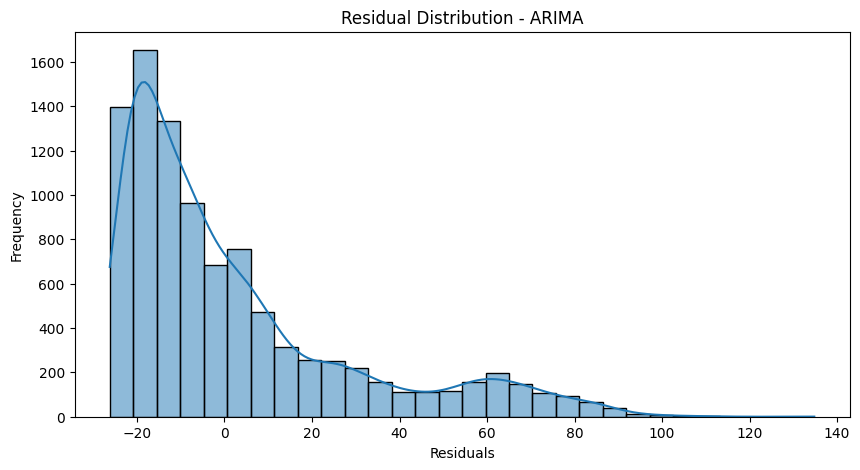

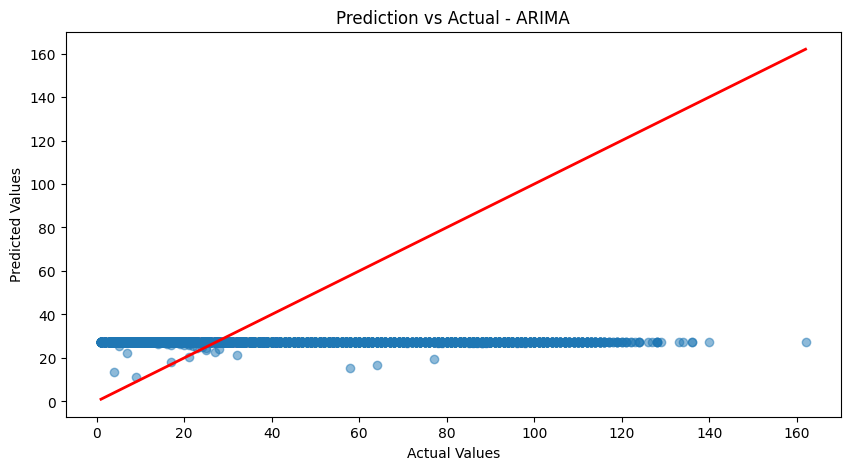

LSTM Performance:
MAE: 12.5087
RMSE: 18.8948
R² Score: 0.5169



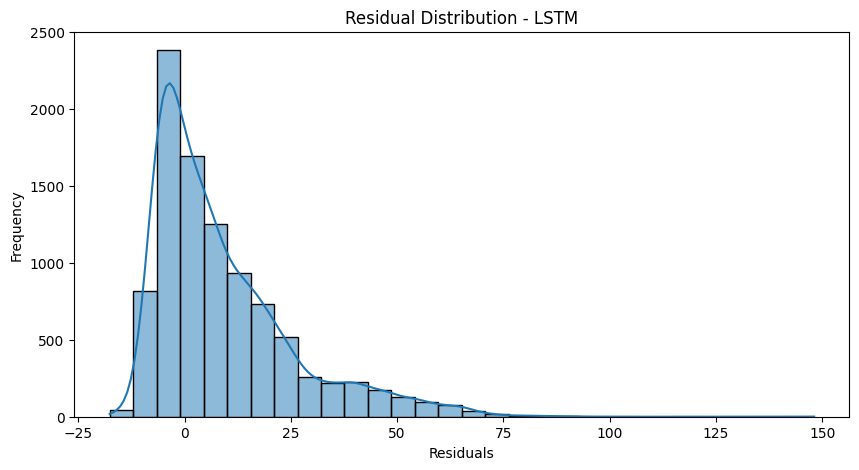

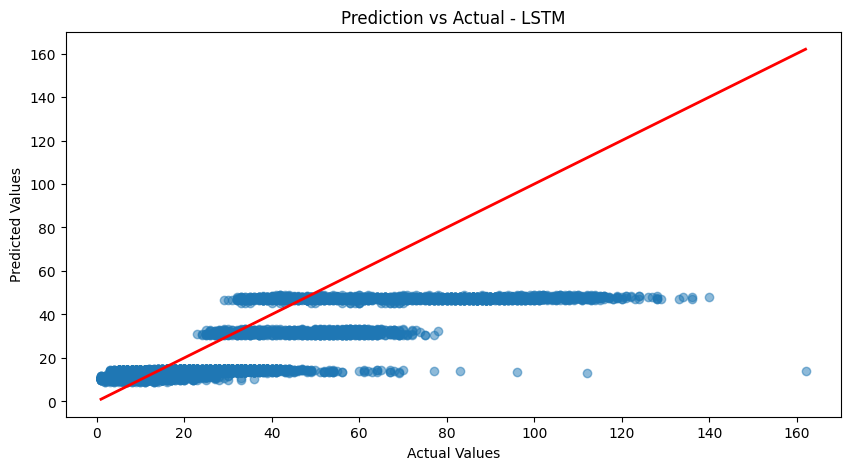

Gradient Boosting Performance:
MAE: 13.4694
RMSE: 21.0841
R² Score: 0.3984



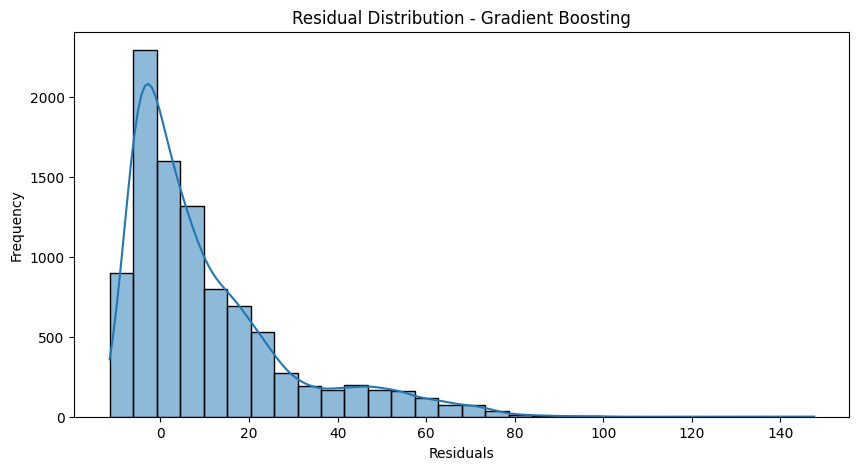

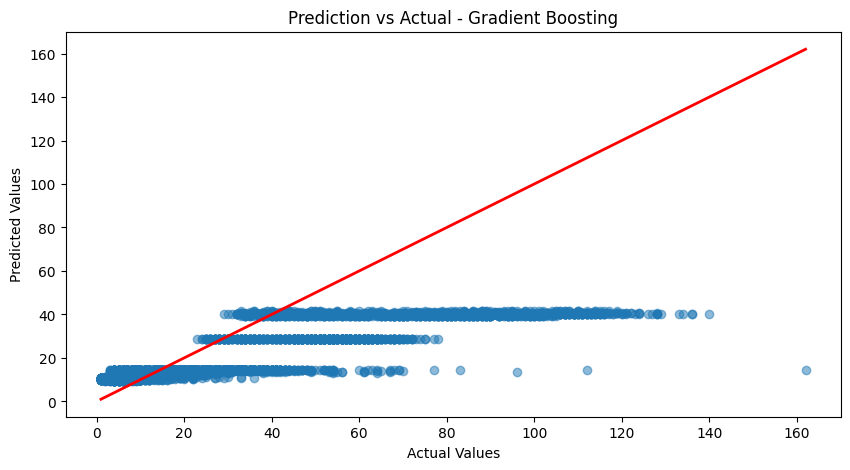

In [40]:
# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")
    
    # Residual Plot
    residuals = y_true - y_pred
    plt.figure(figsize=(10,5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residual Distribution - {model_name}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()
    
    # Prediction vs Actual
    plt.figure(figsize=(10,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r', lw=2)
    plt.title(f"Prediction vs Actual - {model_name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

evaluate_model(y_valid, arima_preds, "ARIMA")
evaluate_model(y_valid, lstm_preds, "LSTM")
evaluate_model(y_valid, gbt_preds, "Gradient Boosting")

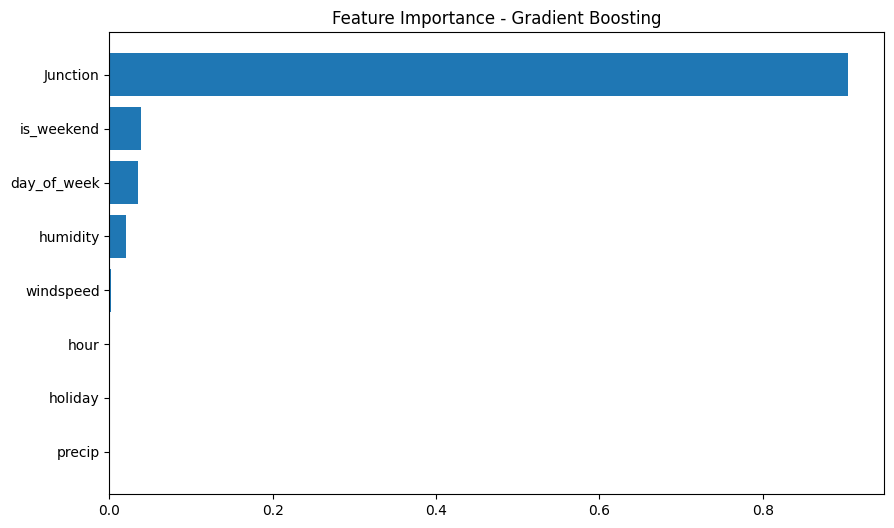

In [41]:
# Feature Importance Plot
importances = gbt_model.best_estimator_.feature_importances_
sorted_idx = importances.argsort()
plt.figure(figsize=(10,6))
plt.barh(X_train.columns[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance - Gradient Boosting")
plt.show()

In [42]:
# Time-Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
cv_results = []
for train_idx, test_idx in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    gbt_model.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = gbt_model.best_estimator_.predict(X_test_fold)
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
    cv_results.append(mae_fold)
    print("MAE (Time-based CV):", mae_fold)

MAE (Time-based CV): 6.985247679756143
MAE (Time-based CV): 7.412958122421736
MAE (Time-based CV): 9.071311928791495
MAE (Time-based CV): 12.50211854831316
MAE (Time-based CV): 11.992219058261773


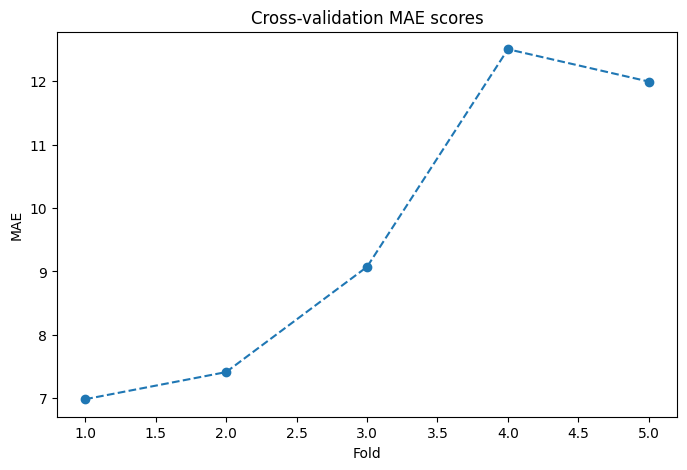

In [43]:
# Cross-validation analysis
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cv_results) + 1), cv_results, marker='o', linestyle='--')
plt.title("Cross-validation MAE scores")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.show()